In [21]:
# imports
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [134]:
yelp_df = pd.read_csv('/Users/parkerharalds/Documents/Lighthouse/Statistical_Modelling_Project/data/yelp_df.csv')
bikes_df = pd.read_csv('/Users/parkerharalds/Documents/Lighthouse/Statistical_Modelling_Project/data/city_bikes.csv')
fsq_df = pd.read_csv('/Users/parkerharalds/Documents/Lighthouse/Statistical_Modelling_Project/data/fsq_df.csv')

In [131]:
yelp_df.head(2)
# bikes_df.head(2)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.menu_url,attributes.open24_hours,attributes.waitlist_reservation,price,station
0,nFxhMiWh2JRfaWW79aj66A,café-portrait-vancouver-2,Café Portrait,https://s3-media1.fl.yelpcdn.com/bphoto/mQyCTA...,False,https://www.yelp.com/biz/caf%C3%A9-portrait-va...,74.0,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",4.4,[],...,V6G 1T2,CA,BC,"['1120 Denman Street', 'Vancouver, BC V6G 1T2'...",NaN,NaN,NaN,False,NaN,00fa94ad698dc4a9e4d708d6fd32f294
1,vZkovAEB5N5l1ZtS6aVDnA,breka-bakery-and-cafe-vancouver-2,Breka Bakery & Cafe,https://s3-media3.fl.yelpcdn.com/bphoto/_AN_B5...,False,https://www.yelp.com/biz/breka-bakery-and-cafe...,370.0,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",3.9,[],...,V6E 1Y4,CA,BC,"['812 Bute Street', 'Vancouver, BC V6E 1Y4', '...",NaN,NaN,NaN,NaN,$,00fa94ad698dc4a9e4d708d6fd32f294


In [11]:
#renaming station_id column for merge
bikes_df = bikes_df.rename(columns={'station_id': 'station'})

In [13]:
main_df = pd.merge(bikes_df,yelp_df,on='station')

In [19]:
#checking shape of main_df against shape of original dataframes.
print('',main_df.shape,'\n',yelp_df.shape,'\n',bikes_df.shape)

 (3864, 36) 
 (3864, 30) 
 (258, 7)


In [38]:
#dropping city as it is redundant
main_df2 = main_df.drop(['city'],axis=1)
#check shape after dropping column
main_df2.shape
main_df = main_df2

In [40]:
#getting an idea of columns in full df
main_df.columns

Index(['station', 'station_name', 'latitude', 'longitude', 'free_bikes',
       'empty_slots', 'id', 'alias', 'name', 'image_url', 'is_closed', 'url',
       'review_count', 'categories', 'rating', 'transactions', 'phone',
       'display_phone', 'distance', 'business_hours', 'coordinates.latitude',
       'coordinates.longitude', 'location.address1', 'location.address2',
       'location.address3', 'location.city', 'location.zip_code',
       'location.country', 'location.state', 'location.display_address',
       'attributes.business_temp_closed', 'attributes.menu_url',
       'attributes.open24_hours', 'attributes.waitlist_reservation', 'price'],
      dtype='object')

In [43]:
#dropping many columns as they do not seem relevant
to_drop = main_df.columns[19:35]
main_df3 = main_df.drop(to_drop,axis=1)
#dropping a few more columns
drop_again = ['alias','image_url','is_closed','url','phone','display_phone']
#forgot one
drop_me = ['categories']
main_df3 = main_df3.drop(drop_me, axis=1)

As I am going to look into if there is a correlation between the number of bikes and the number of cafes, I decided to drop many columns from the main_df. This could have been done earlier when making the api calls; however, I decided I would like to grab more data than I need at this time from those calls. That way I can practice with the data in the future.

I will use main_df3 going forward:

In [ ]:
main_df3.head(3)

The city_bikes api pulls real time data which means the free_bikes and empty_slots can change for each station depending on the time of the api call. I have created a total bikes column to see if the total possible number of bikes per station will affect anything in the model.

In [53]:
#adding a total bikes column that is the sum of free bikes and empty slots
main_df3['total_bikes'] = main_df3['free_bikes'] + main_df3['empty_slots']

In [56]:
pivot_df3 = main_df3.pivot_table(
                        index='station',
                        values=['free_bikes','empty_slots','total_bikes','review_count','rating','distance','name'],
                        aggfunc={'free_bikes': 'mean','empty_slots': 'mean',
                                'total_bikes': 'mean','review_count': ['mean', 'max', 'min'],
                                'rating': ['mean', 'max', 'min'], 'distance':['mean', 'max', 'min'],
                                'name': 'count'})
# pivot_df3

In [109]:
#reorderd df for better readability
re_ordered = ['empty_slots','free_bikes','total_bikes','distance','name','rating','review_count']
station_df = pivot_df3[re_ordered]
station_df = station_df.rename(columns={'name':'cafes'})

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

I wanted to look at the total number of bikes for a station to see if there was any relationship with the number of cafes nearby:

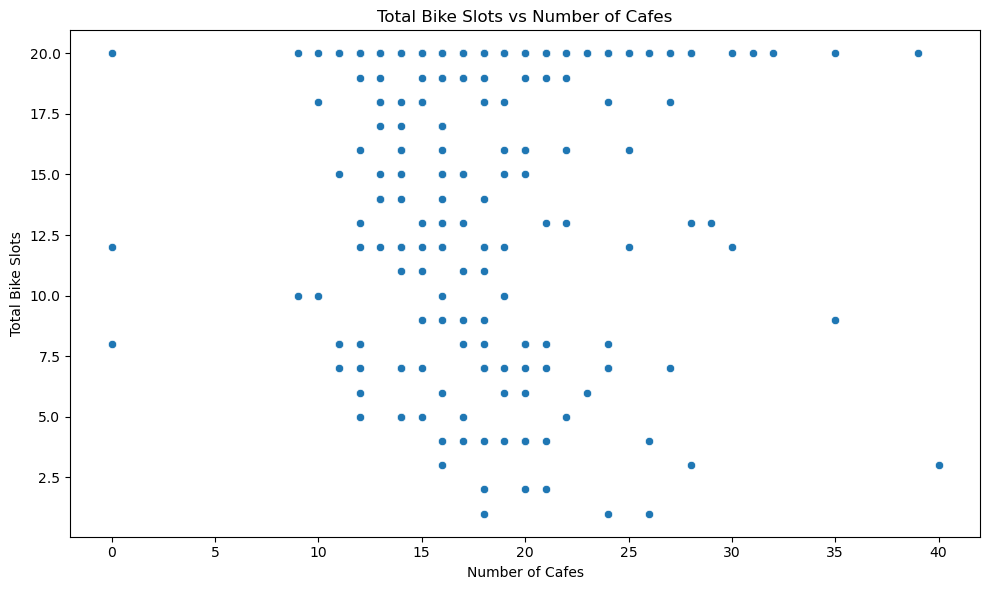

In [111]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_df,x=station_df['total_bikes']['mean'], y=station_df['cafes']['count'])

# Adding labels and title
plt.title('Total Bike Slots vs Number of Cafes')
plt.xlabel('Number of Cafes')
plt.ylabel('Total Bike Slots')
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

This shows that there is..... maybe..... a weak relationship between the total bikes and the number of cafes. 

This plot also raised another good point though: Why are there stations with zero total bike slots?

In [163]:
zero_check = station_df[station_df['total_bikes']['mean']!=0]

In [164]:
print(len(station_df),len(zero_check))

256 253


3 stations have zero bikes at the station. I am deeming these useless and dropping them by saving station_df as the filtered df of all non-zero rows

In [165]:
station_df1 = zero_check

In [166]:
station_df1.head()

empty_slots free_bikes total_bikes  \
                                        mean       mean        mean   
station                                                               
00fa94ad698dc4a9e4d708d6fd32f294         7.0       11.0        18.0   
012d3e06901cc222b1c2cf0a2ace3a29        13.0        1.0        14.0   
029a505bd4422a1afd127987757f71a6        14.0        0.0        14.0   
0438114d2e6b96118de69bc9775bb21e        14.0       11.0        25.0   
0459b7e93703980b853cd65a9dc60596         9.0        5.0        14.0   

                                     distance                         cafes  \
                                          max        mean         min count   
station                                                                       
00fa94ad698dc4a9e4d708d6fd32f294  1199.915982  810.193384  350.540969    18   
012d3e06901cc222b1c2cf0a2ace3a29   951.596216  578.035308   71.274224    12   
029a505bd4422a1afd127987757f71a6  1138.992659  663.138811  145.760213    20   
0438114d2e6b96118de69bc9775bb21e   876.702883  539.830458   88.697075    12   
0459b7e93703980b853cd65a9dc60596  1281.087849  844.545892  217.292249    16   

                                 rating                review_count  \
                                    max      mean  min          max   
station                                                               
00fa94ad698dc4a9e4d708d6fd32f294    5.0  3.616667  0.0        370.0   
012d3e06901cc222b1c2cf0a2ace3a29    4.6  3.991667  3.2        519.0   
029a505bd4422a1afd127987757f71a6    4.8  3.445000  0.0        103.0   
0438114d2e6b96118de69bc9775bb21e    5.0  3.608333  0.0        189.0   
0459b7e93703980b853cd65a9dc60596    5.0  3.643750  0.0        285.0   

                                                   
                                        mean  min  
station                                            
00fa94ad698dc4a9e4d708d6fd32f294   57.611111  0.0  
012d3e06901cc222b1c2cf0a2ace3a29  120.583333  1.0  
029a505bd4422a1afd127987757f71a6   19.050000  0.0  
0438114d2e6b96118de69bc9775bb21e   31.000000  0.0  
0459b7e93703980b853cd65a9dc60596   39.750000  0.0

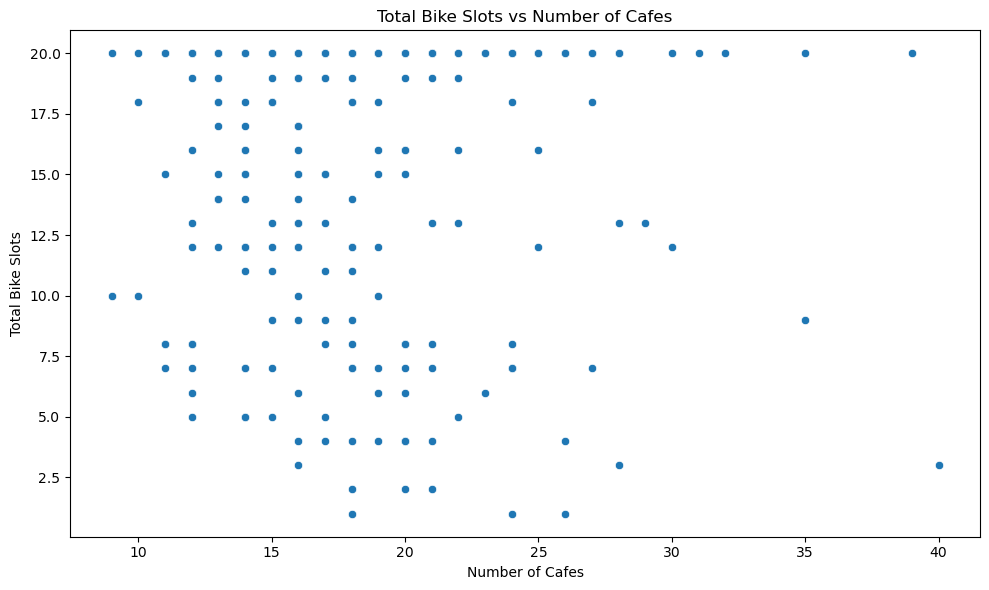

In [117]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_df1,x=station_df1['total_bikes']['mean'], y=station_df1['cafes']['count'])

# Adding labels and title
plt.title('Total Bike Slots vs Number of Cafes')
plt.xlabel('Number of Cafes')
plt.ylabel('Total Bike Slots')
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

A pairplot was also used to look at the multiple variables together:

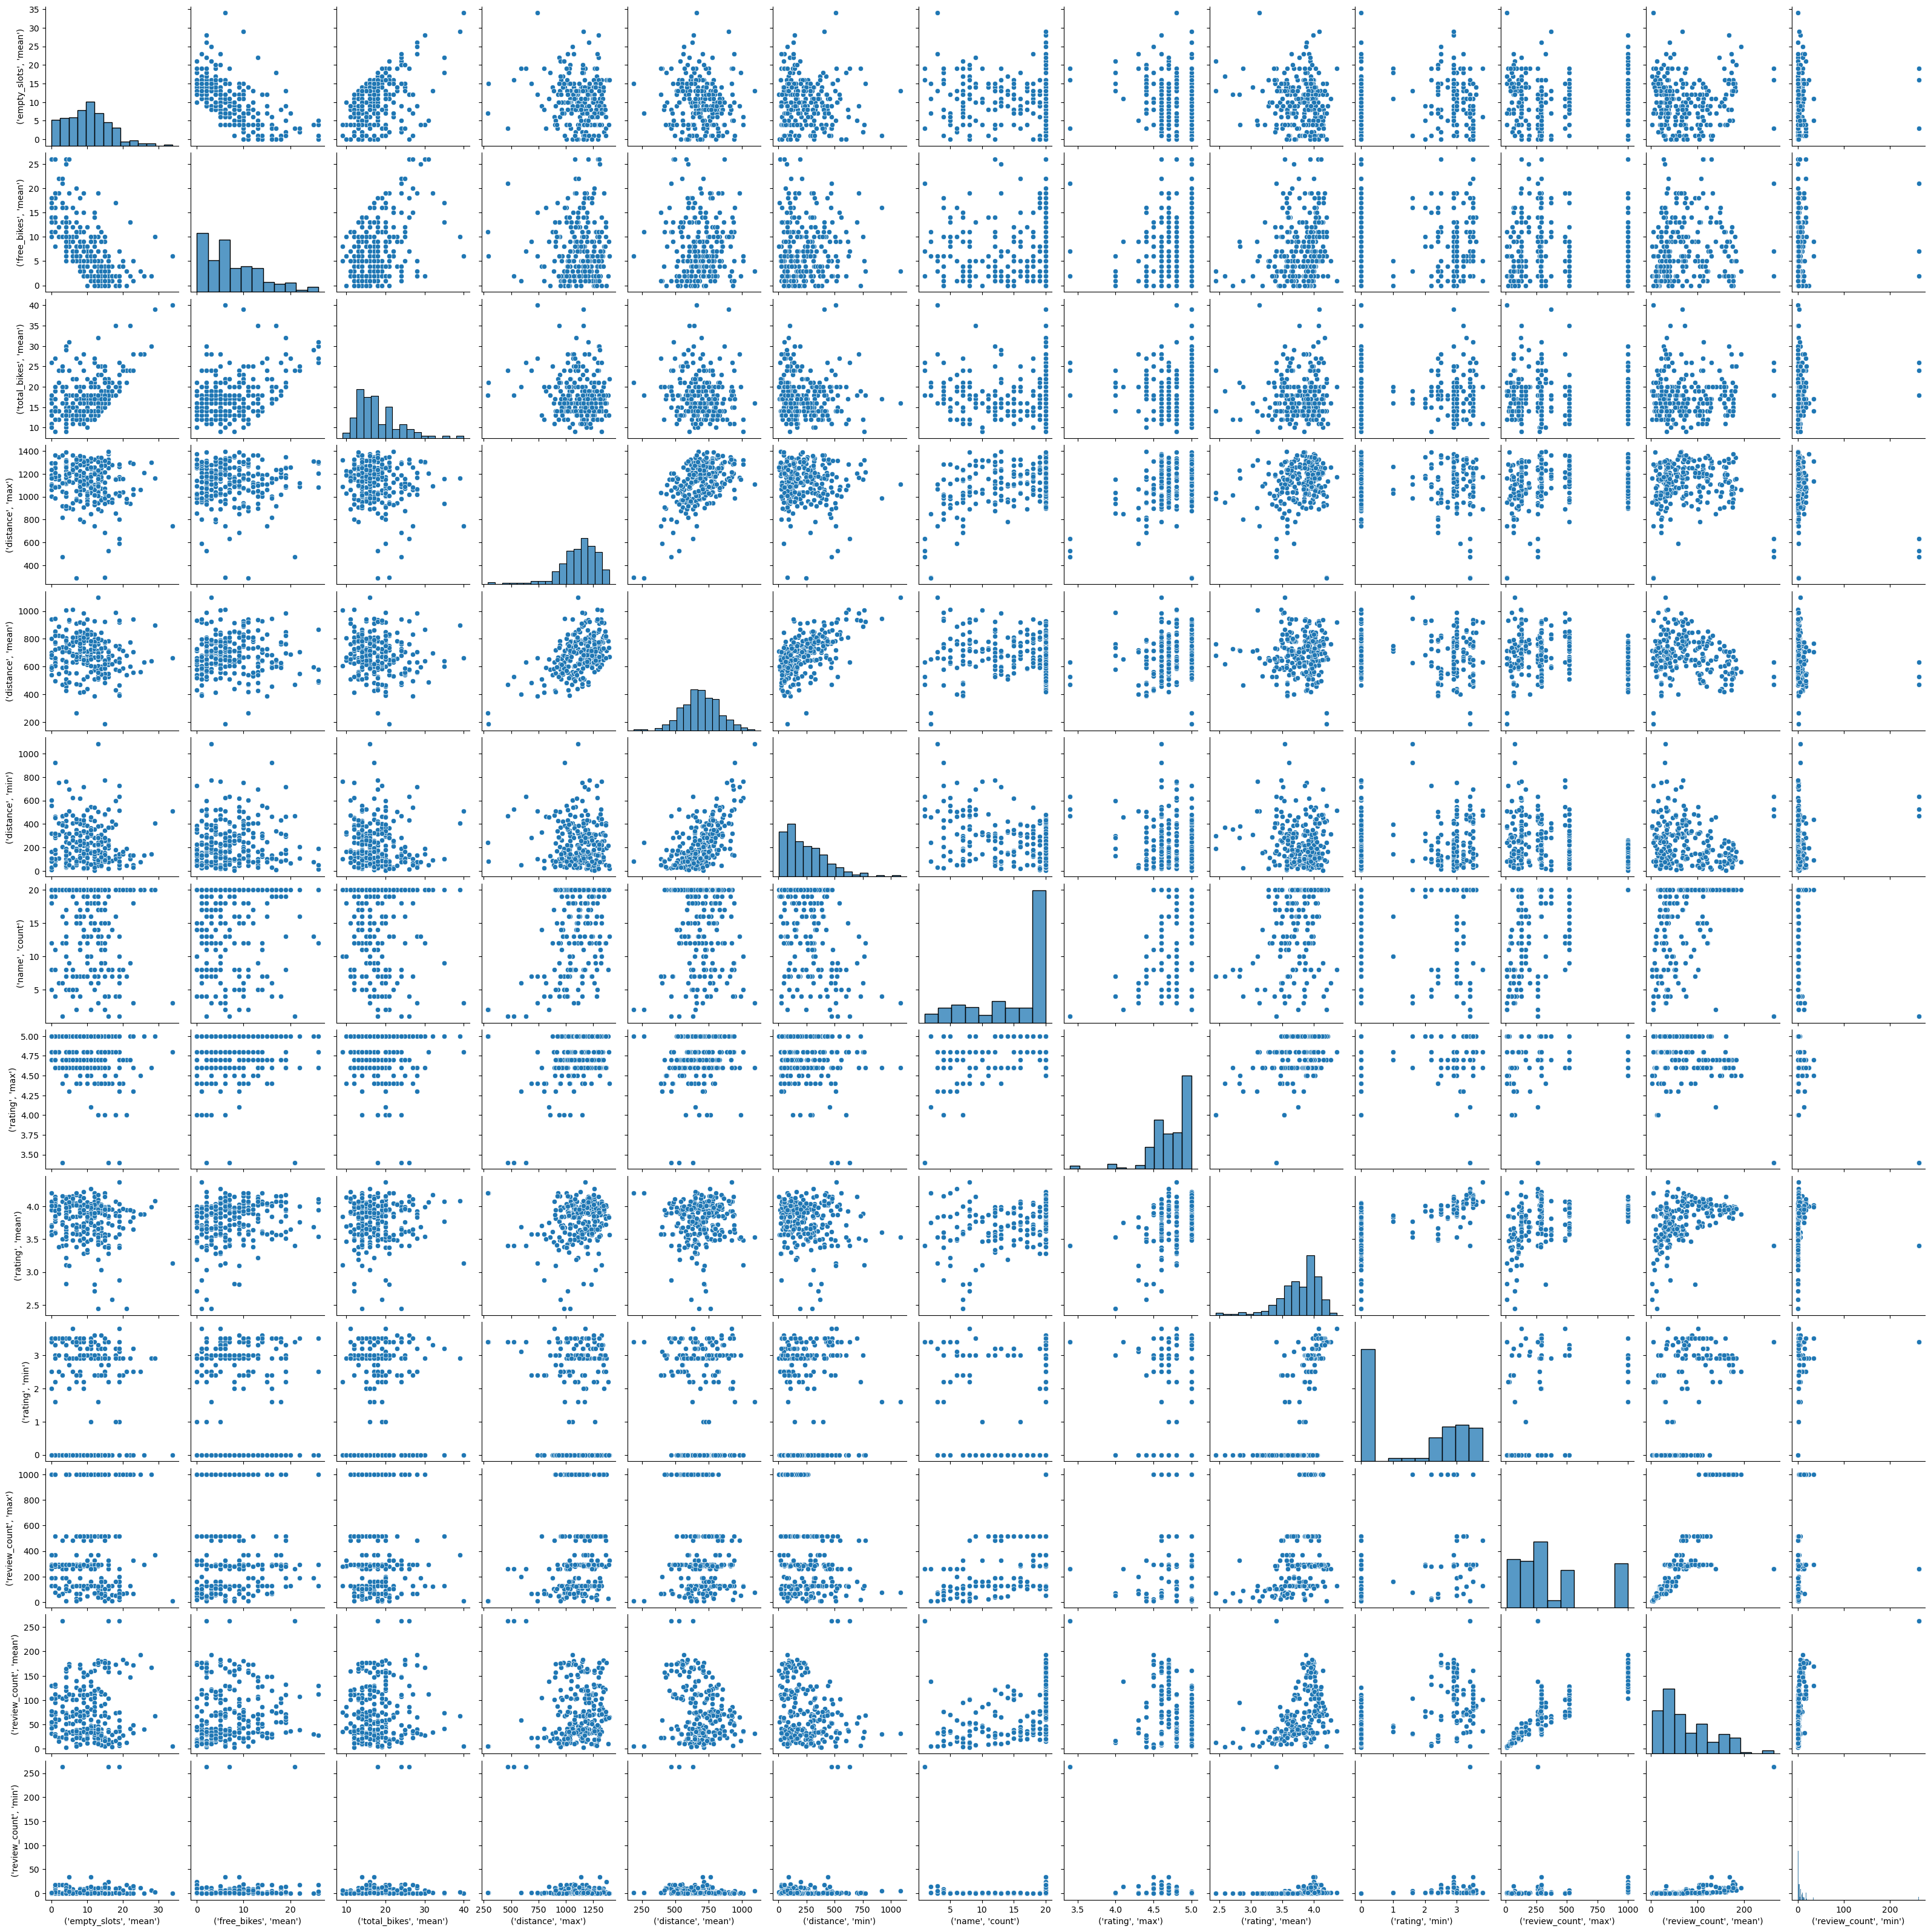

In [107]:
sns.pairplot(station_df1)
plt.show()

In [167]:
#fixing multilevel column names and storing as new df
station_df2 = station_df1.copy()
station_df2.columns = ['_'.join(col).strip() for col in station_df1.columns.values]
#storing this data to use in model
station_df2.to_csv('model_data',index=False,sep=',')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [118]:
import sqlite3
from sqlite3 import Error

In [120]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [121]:
#creating db in the project data folder
connection = create_connection('/Users/parkerharalds/Documents/Lighthouse/Statistical_Modelling_Project/data/sm_app.sqlite')

Connection to SQLite DB successful


In [132]:
bikes_df.to_sql('bikes',connection,if_exists='replace',index=False)

258

In [133]:
yelp_df.to_sql('yelp',connection,if_exists='replace',index=False)

3864

In [135]:
fsq_df.to_sql('fsq',connection,if_exists='replace',index=False)

10660

In [138]:
main_df.to_sql('yelp_bikes_combo',connection,if_exists='replace',index=False)

3864

Look at the data before and after the join to validate your data.

In [158]:
#getting length of bikes table
bikes_res = pd.read_sql_query("SELECT COUNT(station) FROM bikes", connection)

In [159]:
bikes_res

,COUNT(station)
0,258


In [153]:
#getting length of yelp table
yelp_res = pd.read_sql_query("SELECT COUNT(id) FROM yelp", connection)

In [154]:
yelp_res

,COUNT(id)
0,3864


In [148]:
#getting length of combined dataframe
merge_res = pd.read_sql_query("SELECT COUNT(station) FROM yelp_bikes_combo", connection)

In [149]:
merge_res

,COUNT(station)
0,3864


The table of merged data 'yelp_bikes_combo' is the same length as the 'yelp' table. This is expected as the merge function performed an inner join between the yelp and bikes dataframes

In [ ]:
close connection